## Dataset description

The dataset is from the U.S. Small Business Administration (SBA) The U.S. SBA was founded in 1953 on the principle of promoting and assisting small enterprises in the U.S. credit market (SBA Overview and History, US Small Business Administration (2015)). Small businesses have been a primary source of job creation in the United States; therefore, fostering small business formation and growth has social benefits by creating job opportunities and reducing unemployment. There have been many success stories of start-ups receiving SBA loan guarantees such as FedEx and Apple Computer. However, there have also been stories of small businesses and/or start-ups that have defaulted on their SBA-guaranteed loans.  
More info on the original dataset: https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied


## Preparation



In [1]:
#Import the necessary modules
import h2o
from h2o.estimators import H2OGeneralizedLinearEstimator
import pandas as pd
import numpy as np
import os
import pickle

import math

from h2o.grid.grid_search import H2OGridSearch

pd.set_option('display.max_columns', 1500)

import warnings
warnings.filterwarnings('ignore')

#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#Start the H2o Cluster
try:
    h2o.cluster().shutdown()
except:
    pass
import psutil

# Initialize H2O using all available CPU cores and 90% of available memory
num_cores = 8
mem_size = 8
h2o.init(nthreads=num_cores, max_mem_size=mem_size)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "20.0.2" 2023-07-18; Java(TM) SE Runtime Environment (build 20.0.2+9-78); Java HotSpot(TM) 64-Bit Server VM (build 20.0.2+9-78, mixed mode, sharing)
  Starting server from /Users/akilsurya.s/ml-fall-2023/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/xg/vfy0jw4x0mn4lpflbsz480gh0000gn/T/tmpnz3s83df
  JVM stdout: /var/folders/xg/vfy0jw4x0mn4lpflbsz480gh0000gn/T/tmpnz3s83df/h2o_akilsurya_s_started_from_python.out
  JVM stderr: /var/folders/xg/vfy0jw4x0mn4lpflbsz480gh0000gn/T/tmpnz3s83df/h2o_akilsurya_s_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,3 months and 11 days
H2O_cluster_name:,H2O_from_python_akilsurya_s_x9gcl6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Load data

In [3]:
import pandas as pd
data = pd.read_csv('SBA_loans_project_1.csv')
data.head(2)

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status
0,0,GLEN BURNIE,MD,21060,"BUSINESS FINANCE GROUP, INC.",VA,811111,7,1.0,6,7,1,1,0,N,743000.0,0.0,743000.0,743000.0,0
1,1,WEST BEND,WI,53095,JPMORGAN CHASE BANK NATL ASSOC,IL,722410,20,1.0,0,0,1,0,N,N,137000.0,0.0,137000.0,109737.0,0


## Dataset preparation and clean-up

Modify and clean-up the dataset as following:
- Replace encode Na/Null values
- Convert the strings styled as '$XXXX.XX' to float values. Columns = ['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']
- Convert MIS_Status to 0/1. Make value "CHGOFF" as 1


In [4]:
values_to_fill = {}
data = data.dropna(axis =0, subset=['MIS_Status'])
for col in data.columns:
    if data[col].isna().any() == True:
        print("Processing column and column type:", col,data[col].dtype)

        if pd.api.types.is_numeric_dtype(data[col].dtype):
            values_to_fill[col] = 0
        else:
            values_to_fill[col] = "Unknown"


data.fillna(value=values_to_fill,inplace=True)

Processing column and column type: City object
Processing column and column type: State object
Processing column and column type: Bank object
Processing column and column type: BankState object
Processing column and column type: NewExist float64
Processing column and column type: RevLineCr object
Processing column and column type: LowDoc object


In [5]:
data.head()

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status
0,0,GLEN BURNIE,MD,21060,"BUSINESS FINANCE GROUP, INC.",VA,811111,7,1.0,6,7,1,1,0,N,743000.0,0.0,743000.0,743000.0,0
1,1,WEST BEND,WI,53095,JPMORGAN CHASE BANK NATL ASSOC,IL,722410,20,1.0,0,0,1,0,N,N,137000.0,0.0,137000.0,109737.0,0
2,2,SAN DIEGO,CA,92128,UMPQUA BANK,OR,0,2,1.0,0,0,1,0,0,N,280000.0,0.0,280000.0,210000.0,0
3,3,WEBSTER,MA,1570,HOMETOWN BANK A CO-OPERATIVE B,MA,621310,7,1.0,0,0,1,1,0,Y,144500.0,0.0,144500.0,122825.0,0
4,4,JOPLIN,MO,64804,U.S. BANK NATIONAL ASSOCIATION,OH,0,2,2.0,0,0,1,0,N,Y,52500.0,0.0,52500.0,42000.0,0


In [6]:
data.isnull().sum()

index                0
City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementGross    0
BalanceGross         0
GrAppv               0
SBA_Appv             0
MIS_Status           0
dtype: int64

In [7]:
values_to_fill

{'City': 'Unknown',
 'State': 'Unknown',
 'Bank': 'Unknown',
 'BankState': 'Unknown',
 'NewExist': 0,
 'RevLineCr': 'Unknown',
 'LowDoc': 'Unknown'}

## Adding new features and interactions

In [8]:

# Feature Engineering - Adding a new column SBA_Bank_Gurantee_Ratio which signifies The portion which is guranteed by the SBA Bank

data['SBA_Bank_Gurantee_Ratio'] = data['SBA_Appv'] / data['GrAppv']




industry_code = data['NAICS']

#Function to take the first 2 digits of the code
def get_code(industry_code):
    return int(str(industry_code)[:2])

## Feature Engineering - Adding a new column namely industry_code
data['industry_code'] = data.NAICS.apply(get_code)

data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809247 entries, 0 to 809246
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   index                    809247 non-null  int64  
 1   City                     809247 non-null  object 
 2   State                    809247 non-null  object 
 3   Zip                      809247 non-null  int64  
 4   Bank                     809247 non-null  object 
 5   BankState                809247 non-null  object 
 6   NAICS                    809247 non-null  int64  
 7   NoEmp                    809247 non-null  int64  
 8   NewExist                 809247 non-null  float64
 9   CreateJob                809247 non-null  int64  
 10  RetainedJob              809247 non-null  int64  
 11  FranchiseCode            809247 non-null  int64  
 12  UrbanRural               809247 non-null  int64  
 13  RevLineCr                809247 non-null  object 
 14  LowD

## Categorical and numerical variables encoding

Encode categorical variables using either one of the techniques below. Don't use LabelEncoder.
- One-hot-encoder for variables with less than 10 valid values. Name your new columns "Original_name"_valid_value
- Target encoder from the following library: https://contrib.scikit-learn.org/category_encoders/index.html . Name your new column "Original_name"_trg
- WOE encoder from the following library: https://contrib.scikit-learn.org/category_encoders/index.html . Name your new column "Original_name"_woe


WOE encoder can be used with numerical variables too.


Example of use for target encoder:
```
import category_encoders as ce

encoder = ce.TargetEncoder(cols=[...])

encoder.fit(X, y)
X_cleaned = encoder.transform(X_dirty)
```

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and test (20%) sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Split the training data into training (60%) and validation (20%) sets
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

# Print the sizes of the resulting datasets
print("Training data size:", train_data.shape[0])
print("Validation data size:", val_data.shape[0])
print("Test data size:", test_data.shape[0])

Training data size: 485547
Validation data size: 161850
Test data size: 161850


In [10]:
from copy import deepcopy
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import category_encoders as ce


#Columns to drop from ML models
cols_to_drop = []
#Categorical encoders disctionary
cat_encoders = {}
#New categorical (encoded) columns
cat_enc_columns = []
label_col = 'MIS_Status'
index_col = 'index'

for col in train_data.drop(columns=[label_col]+[index_col]).columns:
  if train_data[col].dtype == 'object':
    if train_data[col].nunique() < 10:
        
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        enc.fit(train_data[[col]])
        result = enc.transform(train_data[[col]])
        ohe_columns = [col+"_"+str(x) for x in enc.categories_[0]]
        cat_enc_columns = cat_enc_columns + ohe_columns
        result_train = pd.DataFrame(result, columns=ohe_columns)
        train_data = pd.concat([train_data, result_train], axis=1)
        '''Encode Testing'''
        result = enc.transform(test_data[[col]])
        result_test = pd.DataFrame(result, columns=ohe_columns)
        test_data = pd.concat([test_data, result_test], axis=1)
        '''Encode Validation'''
        result = enc.transform(val_data[[col]])
        result_val = pd.DataFrame(result, columns=ohe_columns)
        val_data = pd.concat([val_data, result_val], axis=1)
        cat_encoders[col] = [deepcopy(enc),"ohe"]
    else:
        
        woe_encoder = ce.WOEEncoder(cols=[col], regularization=1, sigma=0.05)
        woe_encoder.fit(train_data[col], train_data[label_col])
        new_col_name = col+"_woe"
        train_data[new_col_name] = woe_encoder.transform(train_data[[col]])
        test_data[new_col_name] = woe_encoder.transform(test_data[[col]])
        val_data[new_col_name] = woe_encoder.transform(val_data[[col]])
        cat_encoders[col] = [deepcopy(woe_encoder),"woe"]
        cat_enc_columns.append(new_col_name)
    cols_to_drop.append(col)

In [11]:
train_data.columns

Index(['index', 'City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'NoEmp',
       'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural',
       'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross', 'GrAppv',
       'SBA_Appv', 'MIS_Status', 'SBA_Bank_Gurantee_Ratio', 'industry_code',
       'City_woe', 'State_woe', 'Bank_woe', 'BankState_woe', 'RevLineCr_woe',
       'LowDoc_0', 'LowDoc_1', 'LowDoc_A', 'LowDoc_C', 'LowDoc_N', 'LowDoc_R',
       'LowDoc_S', 'LowDoc_Unknown', 'LowDoc_Y'],
      dtype='object')

In [12]:
print("Training data size:", train_data.shape[0])
print("Validation data size:", val_data.shape[0])
print("Test data size:", test_data.shape[0])

Training data size: 679987
Validation data size: 291286
Test data size: 291355


In [13]:
train_data = train_data.dropna(subset=label_col)
val_data = val_data.dropna(subset=label_col)
test_data = test_data.dropna(subset=label_col)

In [14]:
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (485547, 36)
Validation data shape: (161850, 36)
Test data shape: (161850, 36)


# Feature engineering using polynomial terms

In [15]:
poly_colname = []
def add_sqr_feature(df, col):
    col_name = col + "_squared"
    df[col_name] = df[col].apply(lambda x: x**2)
    poly_colname.append(col_name)
    return df

In [16]:
def add_cubic_feature(df, column_name):
    new_column_name = column_name + "cube"
    df[new_column_name] = df[column_name] ** 3
    poly_colname.append(new_column_name)
    return df



In [17]:
#Feature engineered columns using interaction features
def add_interaction_features(train, valid, test):
    # Create interaction features 
    interaction_cols = ["DisbursementGross_sc", "SBA_Bank_Gurantee_Ratio_sc"]
    for i in range(len(interaction_cols)):
        for j in range(i+1, len(interaction_cols)):
            colname = interaction_cols[i] + "_" + interaction_cols[j]+ "interaction"
            train[colname] = train[interaction_cols[i]] * train[interaction_cols[j]]
            valid[colname] = valid[interaction_cols[i]] * valid[interaction_cols[j]]
            test[colname] = test[interaction_cols[i]] * test[interaction_cols[j]]
            selected_columns.append(colname)
    return train, valid, test

# Model Training



In [18]:
#Columns to scale
cols_numerical_sc = []
cols_numerical_orig = []
for col in train_data.drop(columns=[label_col]+cat_enc_columns+cols_to_drop+[index_col]):
    if pd.api.types.is_numeric_dtype(train_data[col].dtype):
        print('Column to process:', col)
        cols_numerical_orig.append(col)

Column to process: Zip
Column to process: NAICS
Column to process: NoEmp
Column to process: NewExist
Column to process: CreateJob
Column to process: RetainedJob
Column to process: FranchiseCode
Column to process: UrbanRural
Column to process: DisbursementGross
Column to process: BalanceGross
Column to process: GrAppv
Column to process: SBA_Appv
Column to process: SBA_Bank_Gurantee_Ratio
Column to process: industry_code


# Feature engineering using Scalar transformations

In [19]:

from sklearn.preprocessing import StandardScaler
num_scalers = {}

for col in train_data[cols_numerical_orig]:
  if pd.api.types.is_numeric_dtype(train_data[col].dtype):
    print("StandardScaler scale of ", col)
    scaler = StandardScaler()
    scaler.fit(train_data[[col]])
    train_data[col+"_sc"] = scaler.transform(train_data[[col]])
    test_data[col+"_sc"] = scaler.transform(test_data[[col]])
    val_data[col+"_sc"] = scaler.transform(val_data[[col]])

    num_scalers[col] = [deepcopy(scaler),"StandardScaler"]
    cols_numerical_sc.append(col+"_sc")
    cols_to_drop.append(col)


print("Original numerical columns:",cols_numerical_orig)

selected_columns = cols_numerical_sc + cat_enc_columns
print("Scaled numerical columns:",cols_numerical_sc)

StandardScaler scale of  Zip
StandardScaler scale of  NAICS
StandardScaler scale of  NoEmp
StandardScaler scale of  NewExist
StandardScaler scale of  CreateJob
StandardScaler scale of  RetainedJob
StandardScaler scale of  FranchiseCode
StandardScaler scale of  UrbanRural
StandardScaler scale of  DisbursementGross
StandardScaler scale of  BalanceGross
StandardScaler scale of  GrAppv
StandardScaler scale of  SBA_Appv
StandardScaler scale of  SBA_Bank_Gurantee_Ratio
StandardScaler scale of  industry_code
Original numerical columns: ['Zip', 'NAICS', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv', 'SBA_Bank_Gurantee_Ratio', 'industry_code']
Scaled numerical columns: ['Zip_sc', 'NAICS_sc', 'NoEmp_sc', 'NewExist_sc', 'CreateJob_sc', 'RetainedJob_sc', 'FranchiseCode_sc', 'UrbanRural_sc', 'DisbursementGross_sc', 'BalanceGross_sc', 'GrAppv_sc', 'SBA_Appv_sc', 'SBA_Bank_Gurantee_Ratio_sc', 'industry_code_sc

In [20]:

# Call the function to add the polynomial expressions  to the dataframes as a part of feature engineering


train_data = add_sqr_feature(train_data, "Bank_woe")
val_data = add_sqr_feature(val_data, "Bank_woe")
test_data = add_sqr_feature(test_data, "Bank_woe")

train_data = add_sqr_feature(train_data, "City_woe")
val_data = add_sqr_feature(val_data, "City_woe")
test_data = add_sqr_feature(test_data, "City_woe")

train_data = add_sqr_feature(train_data, "BankState_woe")
val_data = add_sqr_feature(val_data, "BankState_woe")
test_data = add_sqr_feature(test_data, "BankState_woe")

train_data = add_sqr_feature(train_data, "UrbanRural_sc")
val_data = add_sqr_feature(val_data, "UrbanRural_sc")
test_data = add_sqr_feature(test_data, "UrbanRural_sc")



print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (485547, 54)
Validation data shape: (161850, 54)
Test data shape: (161850, 54)


In [21]:

# Call the function to add the interaction features to the dataframes as a part of feature engineering
train_data, val_data, test_data = add_interaction_features(train_data, val_data, test_data)

In [22]:

selected_columns = cols_numerical_sc + cat_enc_columns

train_hf = h2o.H2OFrame(train_data)
val_hf = h2o.H2OFrame(val_data)
test_hf = h2o.H2OFrame(test_data)
print("Predictor columns:", selected_columns)



Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Predictor columns: ['Zip_sc', 'NAICS_sc', 'NoEmp_sc', 'NewExist_sc', 'CreateJob_sc', 'RetainedJob_sc', 'FranchiseCode_sc', 'UrbanRural_sc', 'DisbursementGross_sc', 'BalanceGross_sc', 'GrAppv_sc', 'SBA_Appv_sc', 'SBA_Bank_Gurantee_Ratio_sc', 'industry_code_sc', 'City_woe', 'State_woe', 'Bank_woe', 'BankState_woe', 'RevLineCr_woe', 'LowDoc_0', 'LowDoc_1', 'LowDoc_A', 'LowDoc_C', 'LowDoc_N', 'LowDoc_R', 'LowDoc_S', 'LowDoc_Unknown', 'LowDoc_Y']


In [23]:
#Ensure the columns are in numreric
def _convert_h2oframe_to_numeric(h2o_frame, training_columns):
    for column in training_columns:
        h2o_frame[column] = h2o_frame[column].asnumeric()
    return h2o_frame

In [24]:
_convert_h2oframe_to_numeric(val_hf, selected_columns)
_convert_h2oframe_to_numeric(train_hf,selected_columns)
_convert_h2oframe_to_numeric(test_hf, selected_columns)
test_hf[label_col] = test_hf[label_col].asnumeric()
train_hfi = train_hf
val_hfi = val_hf
test_hfi = test_hf


allcolumns=selected_columns+poly_colname

# Generic GLM model to determine the model performance

In [25]:

glm = H2OGeneralizedLinearEstimator(nfolds=0, seed=123, solver="L_BFGS",
                                    model_id='glm_v1',family="binomial", lambda_search=True)

glm.train(x= selected_columns, y= label_col, training_frame=train_hf,validation_frame=val_hf)

model_summary = glm.summary()
model_summary

print("Best accuracy threshold:",glm.model_performance(test_hf).accuracy()[0][0],"\n",
      " Accuracy:",
      glm.model_performance(test_hf).accuracy()[0][1])
print("Best F1 threshold:",glm.model_performance(test_hf).F1()[0][0],"\n",
      " F1:",
      glm.model_performance(test_hf).F1()[0][1])
print("Model AUC:", glm.model_performance(test_hf).auc())
print("Model AUCPR:", glm.model_performance(test_hf).aucpr())

glmall = H2OGeneralizedLinearEstimator(nfolds=0, seed=123, solver="L_BFGS",
                                    model_id='glm_all',family="binomial", lambda_search=True)
glmall.train(x= allcolumns, y= label_col, training_frame=train_hfi,validation_frame=val_hfi)
print("Best accuracy threshold:",glmall.model_performance(test_hfi).accuracy()[0][0],"\n",
      " Accuracy:",
      glmall.model_performance(test_hfi).accuracy()[0][1])
print("Best F1 threshold:",glmall.model_performance(test_hfi).F1()[0][0],"\n",
      " F1:",
      glmall.model_performance(test_hfi).F1()[0][1])
print("Model AUC:", glmall.model_performance(test_hfi).auc())
print("Model AUCPR:", glmall.model_performance(test_hfi).aucpr())


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Best accuracy threshold: 0.29167072321014414 
  Accuracy: 0.8249860982391103
Best F1 threshold: 0.23862685523725252 
  F1: 0.3974039347460842
Model AUC: 0.6939112486738039
Model AUCPR: 0.32643776700961474
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Best accuracy threshold: 0.3045452750116448 
  Accuracy: 0.8245288847698486
Best F1 threshold: 0.23459815196931447 
  F1: 0.3995289932230142
Model AUC: 0.6970807989095982
Model AUCPR: 0.32454143346696895


## Model Tuning

Choose one model from the above list. You should provide reasoning on why you have picked the model over others. Perform tuning for the selected model:
- Hyper-parameter tuning. Your hyper-parameter search space should have at least 50 combinations.
- To avoid overfitting and provide you with reasonable estimate of model performance on hold-out dataset, you will need to split your dataset as following:
    - Train, will be used to train model
    - Validation, will be used to validate model each round of training
    - Testing, will be used to provide final performance metrics, used only once on the final model
- Feature engineering. See project description

**Selelct final model that produces best performance on the Test dataset.**
- For the best model, calculate probability threshold to maximize F1.

# Try important columns alone

In [26]:

important_columns = [ 'DisbursementGross_sc_SBA_Bank_Gurantee_Ratio_scinteraction','DisbursementGross_sc', 'BalanceGross_sc', 'GrAppv_sc', 'SBA_Appv_sc', 'SBA_Bank_Gurantee_Ratio_sc', 'industry_code_sc']


In [27]:
# Define the hyperparameters for the GLM model
hyperparams4 = {'alpha': [0.5, 0.7, 0.9], 'lambda': [1e-5, 1e-4, 1e-3]}

# Create an H2O GLM estimator with the defined hyperparameters
glm4 = H2OGeneralizedLinearEstimator(nfolds=0, seed=123, solver="L_BFGS",
                                    model_id='glm_v1', family="binomial", lambda_search=True,
                                    standardize=False, intercept=True)

# Create a grid search object with the GLM estimator, the weights and hyperparameters to test
grid4 = H2OGridSearch(model=glm4, grid_id='grid_search1', hyper_params=hyperparams4,
                     search_criteria={'strategy': 'Cartesian'})

# Train the grid search object on your dataset
grid4.train(x= important_columns, y= label_col, training_frame=train_hfi,validation_frame=val_hfi)

model4_summary = grid4.summary()

# Get the grid results, sorted by validation AUCPR
gridperf4 = grid4.get_grid(sort_by='aucpr', decreasing=True)
gridperf4

# Grab the top DRF model, chosen by validation AUCPR
best_drf4 = gridperf4.models[0]

# Now let's evaluate the model performance on a Validation set
# We should see same metric as in the grid
best_drf_perf4 = best_drf4.model_performance(val_hfi)
best_drf_perf4.aucpr()

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_drf_perf4 = best_drf4.model_performance(test_data=test_hfi)
best_drf_perf4.aucpr()

print("Best accuracy threshold:",best_drf4.model_performance(test_hfi).accuracy()[0][0],"\n",
      " Accuracy:",
      best_drf4.model_performance(test_hf).accuracy()[0][1])
print("Best F1 threshold:",best_drf4.model_performance(test_hfi).F1()[0][0],"\n",
      " F1:",
      best_drf4.model_performance(test_hfi).F1()[0][1])
print("Model AUC:", best_drf4.model_performance(test_hfi).auc())
print("Model AUCPR:", best_drf4.model_performance(test_hfi).aucpr())


glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


Model Id,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
grid_search1_model_1,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 1.0E-5 )","nlambda = 100, lambda.max = 0.1316, lambda.min = 1.0E-5, lambda.1se = -1.0",7,7,6,py_28_sid_b843
grid_search1_model_2,binomial,logit,"Elastic Net (alpha = 0.7, lambda = 1.0E-5 )","nlambda = 100, lambda.max = 0.09403, lambda.min = 1.0E-5, lambda.1se = -1.0",7,7,6,py_28_sid_b843
grid_search1_model_3,binomial,logit,"Elastic Net (alpha = 0.9, lambda = 1.0E-5 )","nlambda = 100, lambda.max = 0.07314, lambda.min = 1.0E-5, lambda.1se = -1.0",7,7,6,py_28_sid_b843
grid_search1_model_4,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 1.0E-4 )","nlambda = 100, lambda.max = 0.1316, lambda.min = 1.0E-4, lambda.1se = -1.0",7,7,7,py_28_sid_b843
grid_search1_model_5,binomial,logit,"Elastic Net (alpha = 0.7, lambda = 1.0E-4 )","nlambda = 100, lambda.max = 0.09403, lambda.min = 1.0E-4, lambda.1se = -1.0",7,7,7,py_28_sid_b843
grid_search1_model_6,binomial,logit,"Elastic Net (alpha = 0.9, lambda = 1.0E-4 )","nlambda = 100, lambda.max = 0.07314, lambda.min = 1.0E-4, lambda.1se = -1.0",7,6,7,py_28_sid_b843
grid_search1_model_7,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 0.001 )","nlambda = 100, lambda.max = 0.1316, lambda.min = 0.001, lambda.1se = -1.0",7,6,11,py_28_sid_b843
grid_search1_model_8,binomial,logit,"Elastic Net (alpha = 0.7, lambda = 0.001 )","nlambda = 100, lambda.max = 0.09403, lambda.min = 0.001, lambda.1se = -1.0",7,6,11,py_28_sid_b843
grid_search1_model_9,binomial,logit,"Elastic Net (alpha = 0.9, lambda = 0.001 )","nlambda = 100, lambda.max = 0.07314, lambda.min = 0.001, lambda.1se = -1.0",7,6,13,py_28_sid_b843


Best accuracy threshold: 0.6166411009473756 
  Accuracy: 0.8243002780352178
Best F1 threshold: 0.16223457604718583 
  F1: 0.3728706964709265
Model AUC: 0.65445496437695
Model AUCPR: 0.2486050527671883


# Perform grid search to determine the best model !

In [28]:
# Define the hyperparameters for the GLM model
hyperparams5 = {'alpha': [0.5, 0.7, 0.9], 'lambda': [1e-5, 1e-4, 1e-3]}


# Set up GLM for binary classification
glm_5 = H2OGeneralizedLinearEstimator(family = 'binomial', model_id = 'glm_5', keep_cross_validation_predictions = True, nfolds =5, fold_assignment = "stratified", balance_classes=True)
# Create a grid search object with the GLM estimator, the weights and hyperparameters to test
grid5 = H2OGridSearch(model=glm_5, grid_id='grid_5', hyper_params=hyperparams5,
                     search_criteria={'strategy': 'Cartesian'})

# Train the grid search object on your dataset
grid5.train(x= important_columns, y= label_col, training_frame=train_hfi,validation_frame=val_hfi)

# Get the grid results, sorted by validation AUCPR
gridperf5 = grid5.get_grid(sort_by='aucpr', decreasing=True)
gridperf5

# Grab the top DRF model, chosen by validation AUCPR
best_drf5 = gridperf5.models[0]

# Now let's evaluate the model performance on a Validation set
# We should see same metric as in the grid
best_drf_perf5 = best_drf5.model_performance(val_hfi)
best_drf_perf5.aucpr()

print("Best accuracy threshold:",best_drf5.model_performance(test_hfi).accuracy()[0][0],"\n",
      " Accuracy:",
      best_drf5.model_performance(test_hf).accuracy()[0][1])
print("Best F1 threshold:",best_drf5.model_performance(test_hfi).F1()[0][0],"\n",
      " F1:",
      best_drf5.model_performance(test_hfi).F1()[0][1])
print("Model AUC:", best_drf5.model_performance(test_hfi).auc())
print("Model AUCPR:", best_drf5.model_performance(test_hfi).aucpr())


glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Best accuracy threshold: 0.5298828775871888 
  Accuracy: 0.8243002780352178
Best F1 threshold: 0.1613446940883304 
  F1: 0.3723246108931994
Model AUC: 0.6544694215362626
Model AUCPR: 0.24873108695711812


In [29]:
important_columns2 = [ 'DisbursementGross_sc_SBA_Bank_Gurantee_Ratio_scinteraction',  'DisbursementGross_sc', 'BalanceGross_sc', 'GrAppv_sc', 'SBA_Appv_sc', 'SBA_Bank_Gurantee_Ratio_sc', 'industry_code_sc', 'FranchiseCode_sc', 'UrbanRural_sc', 'industry_code_sc', 'City_woe', 'State_woe']


# Lets add  few more columns to see if it improves the performance

In [30]:

# Define the hyperparameters for the GLM model
hyperparams7 = {'alpha': [0.5, 0.7, 0.9], 'lambda': [1e-5, 1e-4, 1e-3]}



# Set up GLM for binary classification
glm_7 = H2OGeneralizedLinearEstimator(family = 'binomial', model_id = 'glm_7', keep_cross_validation_predictions = True, nfolds =5, fold_assignment = "stratified", balance_classes=True)
# Create a grid search object with the GLM estimator, the weights and hyperparameters to test
grid7 = H2OGridSearch(model=glm_7, grid_id='grid_7', hyper_params=hyperparams7,
                     search_criteria={'strategy': 'Cartesian'})

# Train the grid search object on your dataset
grid7.train(x= important_columns2, y= label_col, training_frame=train_hfi,validation_frame=val_hfi)

# Get the grid results, sorted by validation AUCPR
gridperf7 = grid7.get_grid(sort_by='aucpr', decreasing=True)
gridperf7

# Grab the top DRF model, chosen by validation AUCPR
best_drf7 = gridperf7.models[0]

# Now let's evaluate the model performance on a Validation set

best_drf_perf7 = best_drf7.model_performance(val_hfi)
best_drf_perf7.aucpr()

print("Best accuracy threshold:",best_drf7.model_performance(test_hfi).accuracy()[0][0],"\n",
      " Accuracy:",
      best_drf7.model_performance(test_hf).accuracy()[0][1])
print("Best F1 threshold:",best_drf7.model_performance(test_hfi).F1()[0][0],"\n",
      " F1:",
      best_drf7.model_performance(test_hfi).F1()[0][1])
print("Model AUC:", best_drf7.model_performance(test_hfi).auc())
print("Model AUCPR:", best_drf7.model_performance(test_hfi).aucpr())

glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Best accuracy threshold: 0.8680010056325882 
  Accuracy: 0.8243064565956132
Best F1 threshold: 0.16634827314665138 
  F1: 0.38806117609864055
Model AUC: 0.6886484787970685
Model AUCPR: 0.29818285372744463


# Check which variables have the highest importance

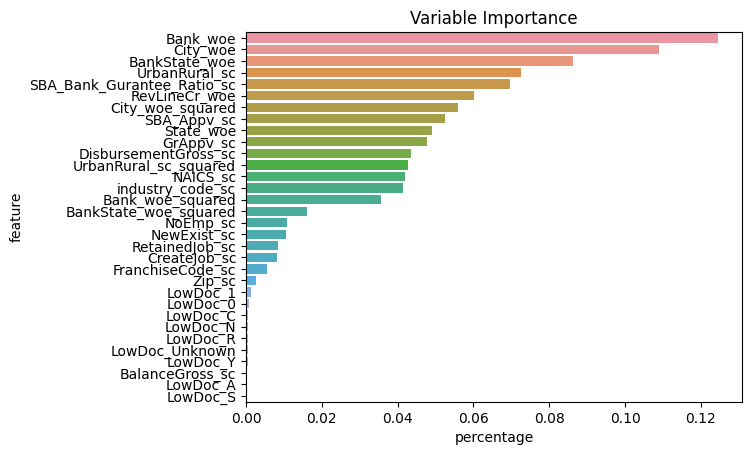

In [31]:


# Get the variable importance measures
varimpall = glmall.varimp()

# Print the table of features and their importance measures
#print(varimpall)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

varimpall_df = pd.DataFrame(varimpall, columns=['feature', 'importance', 'scaled_importance', 'percentage'])
sns.barplot(x='percentage', y='feature', data=varimpall_df)
plt.title('Variable Importance')
plt.show()

In [32]:
poly_imp = important_columns2 + poly_colname

# Let's include important polinomial expressions also


glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Best accuracy threshold: 0.9159436471052971 
  Accuracy: 0.824318813716404
Best F1 threshold: 0.18035572401955216 
  F1: 0.3969271193749937
Model AUC: 0.7045795426942956
Model AUCPR: 0.31019995622951974
[('UrbanRural_sc', 0.5255661010742188, 1.0, 0.23472618943145185), ('City_woe', 0.4758823812007904, 0.905466277653984, 0.21253664901240063), ('UrbanRural_sc_squared', 0.32907113432884216, 0.6261270155290548, 0.14696840845522252), ('Bank_woe_squared', 0.29089900851249695, 0.5534965210235603, 0.12992012924342577), ('SBA_Appv_sc', 0.28497108817100525, 0.5422174063139634, 0.12727262562748187), ('State_woe', 0.09427473694086075, 0.1793775069361781, 0.042104598672842906), ('DisbursementGross_sc', 0.07982084900140762, 0.1518759464095185, 0.035649262167001664), ('DisbursementGross_sc_SBA_Bank_Gurantee_Ratio_scinteraction', 0.07815974205732346, 0.14871534122457794, 0.03490738535564328), ('SBA_Bank_Guran

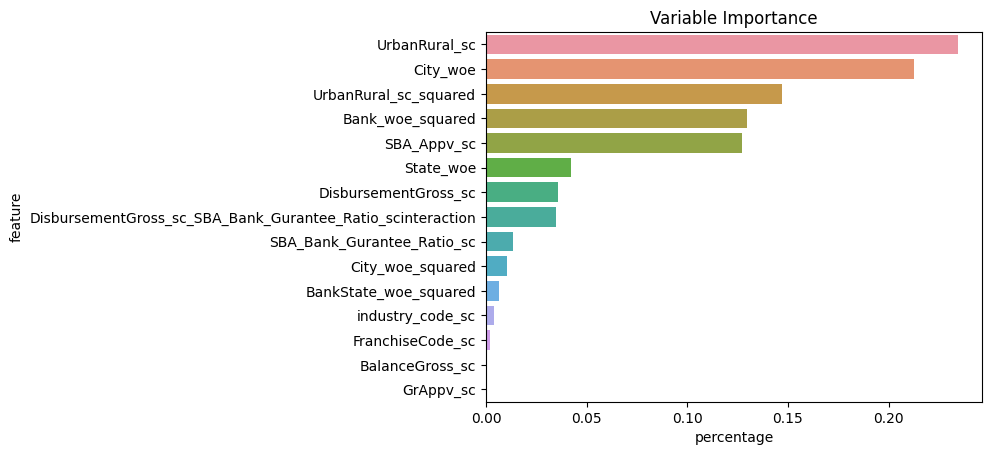

In [33]:

# Define the hyperparameters for the GLM model
hyperparamsfinal = {'alpha': [0.3, 0.5, 0.7, 0.9], 'lambda': [1e-5, 1e-4, 1e-3]}



# Set up GLM for binary classification
glm_final = H2OGeneralizedLinearEstimator(family = 'binomial', model_id = 'glmfinal', keep_cross_validation_predictions = True, nfolds =7, fold_assignment = "stratified", balance_classes=True)
# Create a grid search object with the GLM estimator, the weights and hyperparameters to test
gridfinal = H2OGridSearch(model=glm_final, grid_id='grid_final', hyper_params=hyperparamsfinal,
                     search_criteria={'strategy': 'Cartesian'})

# Train the grid search object on your dataset
gridfinal.train(x= poly_imp, y= label_col, training_frame=train_hfi,validation_frame=val_hfi)

# Get the grid results, sorted by validation AUCPR
gridperffinal = gridfinal.get_grid(sort_by='aucpr', decreasing=True)
gridperffinal

# Grab the top DRF model, chosen by validation AUCPR
best_final = gridperffinal.models[0]

# Now let's evaluate the model performance on a Validation set
# We should see same metric as in the grid
best_glm_final = best_final.model_performance(val_hfi)
best_glm_final.aucpr()

print("Best accuracy threshold:",best_final.model_performance(test_hfi).accuracy()[0][0],"\n",
      " Accuracy:",
      best_final.model_performance(test_hf).accuracy()[0][1])
print("Best F1 threshold:",best_final.model_performance(test_hfi).F1()[0][0],"\n",
      " F1:",
      best_final.model_performance(test_hfi).F1()[0][1])
print("Model AUC:", best_final.model_performance(test_hfi).auc())
print("Model AUCPR:", best_final.model_performance(test_hfi).aucpr())


# Get the variable importance measures
polyvar = best_final.varimp()

# Print the table of features and their importance measures
print(polyvar)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

polyvar_df = pd.DataFrame(polyvar, columns=['feature', 'importance', 'scaled_importance', 'percentage'])
sns.barplot(x='percentage', y='feature', data=polyvar_df)
plt.title('Variable Importance')
plt.show()

In [34]:
# Sort by scaled_importance in descending order and select the top 10 features
top10 = polyvar_df.sort_values(by='scaled_importance', ascending=False).head(10)

# Fetch the feature names and importance values as numpy arrays
top10_features = top10['feature'].values



In [35]:
top10_features

array(['UrbanRural_sc', 'City_woe', 'UrbanRural_sc_squared',
       'Bank_woe_squared', 'SBA_Appv_sc', 'State_woe',
       'DisbursementGross_sc',
       'DisbursementGross_sc_SBA_Bank_Gurantee_Ratio_scinteraction',
       'SBA_Bank_Gurantee_Ratio_sc', 'City_woe_squared'], dtype=object)


# Final model based on top ten features!

In [36]:

# Define the hyperparameters for the GLM model
hyperparamsfinale = {'alpha': [0.3, 0.5, 0.7, 0.9], 'lambda': [1e-5, 1e-4, 1e-3]}

# Set up GLM for binary classification
glm_finale = H2OGeneralizedLinearEstimator(family = 'binomial', model_id = 'glmfinale', keep_cross_validation_predictions = True, nfolds =7, fold_assignment = "stratified", balance_classes=True)



# Create a grid search object with the GLM estimator, the weights and hyperparameters to test
gridfinale = H2OGridSearch(model=glm_finale, grid_id='grid_finale', hyper_params=hyperparamsfinale,
                     search_criteria={'strategy': 'Cartesian'})

# Train the grid search object on your dataset
gridfinale.train(x= top10_features, y= label_col, training_frame=train_hfi,validation_frame=val_hfi)

# Get the grid results, sorted by validation AUCPR
gridperffinale = gridfinale.get_grid(sort_by='aucpr', decreasing=True)
gridperffinale

# Grab the top DRF model, chosen by validation AUCPR
best_finale = gridperffinale.models[0]

# Now let's evaluate the model performance on a Validation set
# We should see same metric as in the grid
best_glm_finale = best_finale.model_performance(val_hfi)
best_glm_finale.aucpr()

print("Best accuracy threshold:",best_finale.model_performance(test_hfi).accuracy()[0][0],"\n",
      " Accuracy:",
      best_finale.model_performance(test_hf).accuracy()[0][1])
print("Best F1 threshold:",best_finale.model_performance(test_hfi).F1()[0][0],"\n",
      " F1:",
      best_finale.model_performance(test_hfi).F1()[0][1])
print("Model AUC:", best_finale.model_performance(test_hfi).auc())
print("Model AUCPR:", best_finale.model_performance(test_hfi).aucpr())



glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Best accuracy threshold: 0.8012165398189097 
  Accuracy: 0.824318813716404
Best F1 threshold: 0.18787968675774774 
  F1: 0.39681039942686863
Model AUC: 0.7044853083588325
Model AUCPR: 0.3102342132041902


# Logistic Regression using SKlearn 

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix

# Define the hyperparameters for the Sklearn Logistic Regression
hyperparamsfinale = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Set up Sklearn Logistic Regression for binary classification
lr_finale = LogisticRegression(solver='liblinear')

# Create a grid search object with the Logistic Regression estimator and the hyperparameters to test
gridfinale = GridSearchCV(estimator=lr_finale, param_grid=hyperparamsfinale, cv=7, scoring='roc_auc')

# Assume 'train_data', 'val_data', and 'test_data' are defined, as well as 'top10_features' and 'label_col'

# Use only the top 10 features columns of X_train for training
X_train_top10 = train_data[top10_features]
Y_train = train_data[label_col]

# Train the grid search object on your training set
gridfinale.fit(X_train_top10, Y_train)

# Get the best hyperparameters and the corresponding AUCROC score on the validation set
best_params = gridfinale.best_params_
best_score = gridfinale.best_score_

# Use the best hyperparameters to fit the Logistic Regression model on the entire training set
lr_finale = LogisticRegression(solver='liblinear', **best_params)
lr_finale.fit(X_train_top10, Y_train)

# Use only the top 10 features columns of X_val for validation
X_val_top10 = val_data[top10_features]
Y_val_top10 = val_data[label_col]

# Calculate predicted probabilities on the validation set for AUCPR
y_pred_prob_val = lr_finale.predict_proba(X_val_top10)[:, 1]
# Calculate AUCPR score on the validation set
aucpr_val = average_precision_score(Y_val_top10, y_pred_prob_val)
print("AUCPR for Validation:", aucpr_val)

# Calculate AUCROC score on the validation set using probabilities
auc_val = roc_auc_score(Y_val_top10, y_pred_prob_val)
print("AUCROC for Validation:", auc_val)

# Use only the top 10 features columns of X_test for prediction
X_test_top10 = test_data[top10_features]
Y_test_top10 = test_data[label_col]

# Calculate predicted probabilities on the test set for AUCPR
y_pred_prob_test = lr_finale.predict_proba(X_test_top10)[:, 1]
# Calculate AUCPR score on the test set
aucpr_test = average_precision_score(Y_test_top10, y_pred_prob_test)
print("AUCPR for Test:", aucpr_test)

# Calculate AUCROC score on the test set using probabilities
auc_test = roc_auc_score(Y_test_top10, y_pred_prob_test)
print("AUCROC for Test:", auc_test)

# Use the trained model to predict on the test set
y_pred_test = lr_finale.predict(X_test_top10)

# Calculate F1 score on the test set
f1 = f1_score(Y_test_top10, y_pred_test, average='macro')
print("F1 for Test:", f1)

# Display the confusion matrix for the test set
print("Test set confusion matrix:")
print(confusion_matrix(Y_test_top10, y_pred_test))


AUCPR for Validation: 0.3089368701541214
AUCROC for Validation: 0.7069049994755696
AUCPR for Test: 0.3104169264962232
AUCROC for Test: 0.7047499742487697
F1 for Test: 0.4912058410493713
Test set confusion matrix:
[[131821   1593]
 [ 27172   1264]]


Through my analysis, it's become clear that a few key attributes are significant predictors of whether a loan will be fully repaid or charged off.

These critical attributes include the loan term duration, the proportion of the loan backed by the SBA, and the geographical location of the borrower (including both state and city). 

Additionally, the variance in interest rates across different states influences the probability of loan repayment.

Although I have experimented with tuning various models using h2o's generalized linear model (GLM) and traditional logistic regression, considering the need for scalability with larger datasets, the h2o GLM seems to be the more appropriate choice despite both models yielding comparable results in the current context.

## Save all artifacts

Save all artifacts needed for scoring function:
- Trained model
- Encoders
- Any other arficats you will need for scoring

**You should stop your notebook here. Scoring function should be in a separate file/notebook.**

In [38]:
import joblib

joblib.dump(scaler, 'std_scaler.bin', compress=True)

# save the model
model_path = h2o.save_model(model=best_finale, force=True)

model_path

'/Users/akilsurya.s/ml-fall-2023/Project-1/grid_finale_model_11'

In [39]:
threshold = 0.24523170136047936
artifacts_dict = {
    "cat_encoders" : cat_encoders,
    "cat_enc_columns": cat_enc_columns,
    "cols_numerical_orig": cols_numerical_orig,
    "top10_features": top10_features,
    "threshold": threshold
}
artifacts_dict_file = open("./artifacts_dict_file.pkl", "wb")
pickle.dump(obj=artifacts_dict, file=artifacts_dict_file)
    
artifacts_dict_file.close() 

In [40]:
top10_features

array(['UrbanRural_sc', 'City_woe', 'UrbanRural_sc_squared',
       'Bank_woe_squared', 'SBA_Appv_sc', 'State_woe',
       'DisbursementGross_sc',
       'DisbursementGross_sc_SBA_Bank_Gurantee_Ratio_scinteraction',
       'SBA_Bank_Gurantee_Ratio_sc', 'City_woe_squared'], dtype=object)

## IMPORTANT - while executing the scoring function have all the files in the default directory
















